# Import Data and Libraries

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashvrdnjain/hotdognothotdog")

print("Path to dataset files:", path)

/home/david/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/david/.cache/kagglehub/datasets/yashvrdnjain/hotdognothotdog/versions/1


In [2]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report

2025-04-30 21:50:23.751859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746067823.764157   83821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746067823.768212   83821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746067823.777654   83821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746067823.777669   83821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746067823.777670   83821 computation_placer.cc:177] computation placer alr

In [3]:
directory = f'{path}/hotdog-nothotdog/train/'
test_directory = f'{path}/hotdog-nothotdog/test/'

In [4]:
train_dataset = image_dataset_from_directory(directory, image_size=(224, 224), validation_split=.2, subset='training', batch_size = 32, seed=123)
validation_dataset = image_dataset_from_directory(directory, image_size=(224, 224), validation_split=.2, subset='validation', batch_size = 32, seed=123)
test_dataset = image_dataset_from_directory(test_directory, image_size=(224, 224), batch_size = 32)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


I0000 00:00:1746067826.370488   83821 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 710 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Found 644 files belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_dataset:
    print('data batch  shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch  shape: (32, 224, 224, 3)
labels batch shape: (32,)


# Step 1: Initial Model Creation

In [6]:
def do_model(num_layers, start_filter, max_filter, dataset_train, dataset_val):
    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    num_filters = start_filter
    dropout_flag = False
    for _ in range(num_layers):
        x = layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
        if dropout_flag == False:
            x = layers.Dropout(.2)(x)
            dropout_flag = True
        num_filters = min(num_filters * 2, max_filter)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath='hotdog_convnet.keras.weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            save_best_only=True
        )
    ]
    history = model.fit(
        dataset_train,
        epochs=30,
        validation_data=dataset_val,
        callbacks=callbacks)
    return model, history

In [7]:
def plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,073 (144.82 KB)

 Trainable params: 37,073 (144.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1746067828.411422   83881 service.cc:152] XLA service 0x7df584004030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746067828.411445   83881 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-30 21:50:28.434546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746067828.584130   83881 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-30 21:50:28.873819: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.12 = (f32[32,8,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.7050, f32[8,3,3,3]{3,2,1,0} %bitcast.7057, f32[8]{0} %bitcast.7673), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_tar

11/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5531 - loss: 34.6026

I0000 00:00:1746067830.915319   83881 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5340 - loss: 11.8040

2025-04-30 21:50:32.290084: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.12 = (f32[32,8,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.423, f32[8,3,3,3]{3,2,1,0} %bitcast.430, f32[8]{0} %bitcast.432), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/david/anaconda3/envs/hotdog-tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-30 21:50:32.364367: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] O

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5339 - loss: 11.7029 - val_accuracy: 0.5233 - val_loss: 0.6908
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5285 - loss: 0.7160 - val_accuracy: 0.5283 - val_loss: 0.6845
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5664 - loss: 0.6929 - val_accuracy: 0.5517 - val_loss: 0.6778
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5653 - loss: 0.7140 - val_accuracy: 0.5883 - val_loss: 0.6670
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6246 - loss: 0.6538 - val_accuracy: 0.6450 - val_loss: 0.6433
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6709 - loss: 0.6223 - val_accuracy: 0.6500 - val_loss: 0.6202
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6476 - loss: 0.6163 - val_accuracy: 0.6183 - val_loss: 0.6460
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6802 - loss: 0.5915 - val_accuracy: 0.6683 - val_loss: 0

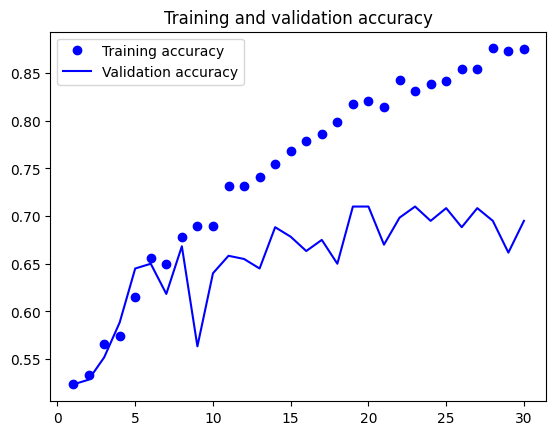

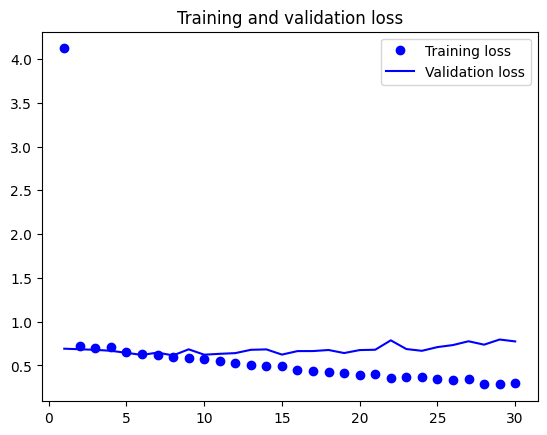

2025-04-30 21:51:15.487339: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.12 = (f32[4,8,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.238, f32[8,3,3,3]{3,2,1,0} %bitcast.245, f32[8]{0} %bitcast.247), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/david/anaconda3/envs/hotdog-tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-30 21:51:15.516750: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omi


--- Classification Report for model ---
              precision    recall  f1-score   support

      hotdog     0.6747    0.6118    0.6417       322
   nothotdog     0.6449    0.7050    0.6736       322

    accuracy                         0.6584       644
   macro avg     0.6598    0.6584    0.6576       644
weighted avg     0.6598    0.6584    0.6576       644



2025-04-30 21:51:15.750288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Train the model
model, history = do_model(4, 8, 64, train_dataset, validation_dataset)

# Plot training history
plot(history)

# Collect true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())  # Ground truth labels
    y_pred.extend(np.round(preds).astype(int).flatten())  # Predicted labels

# Print classification report
print(f"\n--- Classification Report for model ---")
print(classification_report(y_true, y_pred, digits=4, target_names=test_dataset.class_names))
